<a href="https://colab.research.google.com/github/abdelrahmanfarghali/guided-projects/blob/master/Copy_of_Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 11.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=6c2306a54da03ac49a037dde939780b80b0144e84f12b76e2231470a5bec0ad6
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=1b1990da472bf799189ab2d28151619c20ec0cba38a246bb7357ddc738ea2825
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-x781dfjb
  Running command git clone --filter=blob:n

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 17.34 MiB/s, done.
Resolving deltas: 100% (3/3), done.


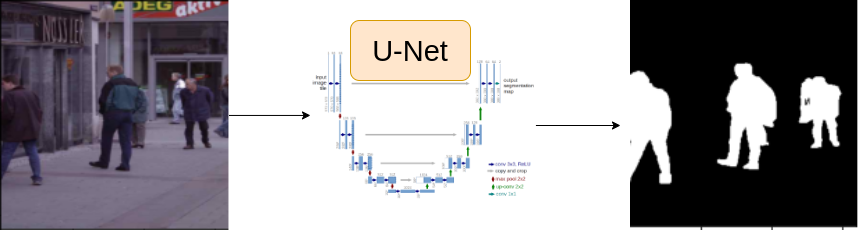

# Some Common Imports

In [40]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [41]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [42]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'
DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [43]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [44]:
row = df.iloc[4]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

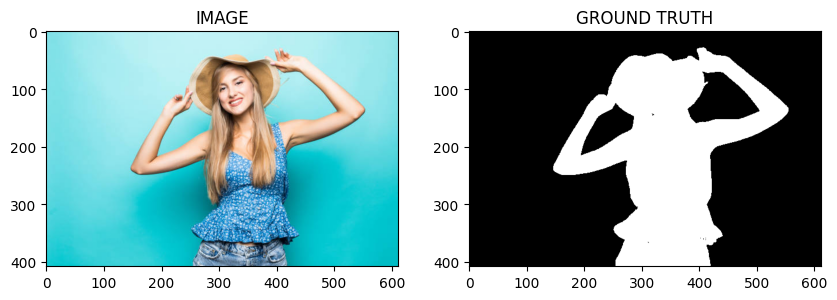

In [45]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [46]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [47]:
import albumentations as A

In [80]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ], is_check_shapes=False)
def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [81]:
from torch.utils.data import Dataset

In [82]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h, w, c)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    # h, w, c > c, h, w (0, 1, 2) > (2, 0, 1)
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [83]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [84]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


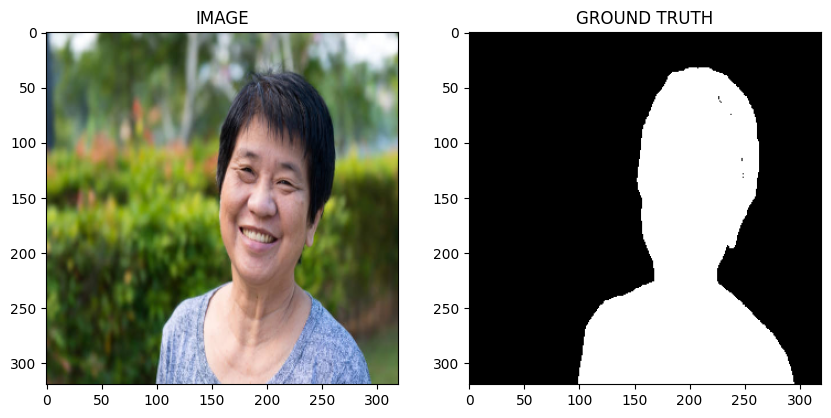

In [85]:
idx = 3

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [86]:
from torch.utils.data import DataLoader

In [87]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [88]:
print(f'total number of batches in trainloader : {len(trainloader)}')
print(f'total number of batches in validloader : {len(validloader)}')

total number of batches in trainloader : 15
total number of batches in validloader : 4


In [89]:
for image, mask in trainloader:
  break

print(f'one image shape {image.shape}', f'one mask shape {mask.shape}')

one image shape torch.Size([16, 3, 320, 320]) one mask shape torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [90]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [91]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()
    self.arc = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
    )

  def forward(self, images, masks=None):
    logits = self.arc(images)
    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2
    return logits

In [92]:
model = SegmentationModel().to(DEVICE)

# Task 7 : Create Train and Validation Function

In [93]:
def train_fn(model, dataloader, optimizer):
  model.train()
  total_loss = 0.0
  for images, masks in tqdm(dataloader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)
    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  return total_loss / len(dataloader)

In [94]:
def eval_fn(model, dataloader, optimizer):
  model.eval()
  total_loss = 0.0
  with torch.no_grad():
    for images, masks in tqdm(dataloader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)
      total_loss += loss.item()

  return total_loss / len(dataloader)

# Task 8 : Train Model

In [95]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [96]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader, optimizer)

  print(f"Epoch : {i+1}")
  print(f"Train Loss : {train_loss:.4f}")
  print(f"Valid Loss : {valid_loss:.4f}")

  if valid_loss < best_valid_loss:
    print(f"Valid loss decreased from {best_valid_loss:.4f} to {valid_loss:.4f}...saving model")
    torch.save(model.state_dict(), 'bestmodel.pt')
    print('model is saved!!')
    best_valid_loss = valid_loss

100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch : 1
Train Loss : 0.8220
Valid Loss : 4.5380
Valid loss decreased from inf to 4.5380...saving model
model is saved!!


100%|██████████| 4/4 [00:00<00:00,  5.97it/s]


Epoch : 2
Train Loss : 0.3723
Valid Loss : 0.3027
Valid loss decreased from 4.5380 to 0.3027...saving model
model is saved!!


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


Epoch : 3
Train Loss : 0.2770
Valid Loss : 0.3394


100%|██████████| 4/4 [00:00<00:00,  6.02it/s]


Epoch : 4
Train Loss : 0.2633
Valid Loss : 0.3161


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


Epoch : 5
Train Loss : 0.2381
Valid Loss : 0.2860
Valid loss decreased from 0.3027 to 0.2860...saving model
model is saved!!


100%|██████████| 4/4 [00:00<00:00,  5.98it/s]


Epoch : 6
Train Loss : 0.2481
Valid Loss : 0.3113


100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


Epoch : 7
Train Loss : 0.2626
Valid Loss : 0.3222


100%|██████████| 4/4 [00:00<00:00,  5.88it/s]


Epoch : 8
Train Loss : 0.1756
Valid Loss : 0.2858
Valid loss decreased from 0.2860 to 0.2858...saving model
model is saved!!


100%|██████████| 4/4 [00:00<00:00,  5.97it/s]


Epoch : 9
Train Loss : 0.1558
Valid Loss : 0.1923
Valid loss decreased from 0.2858 to 0.1923...saving model
model is saved!!


100%|██████████| 4/4 [00:00<00:00,  6.13it/s]


Epoch : 10
Train Loss : 0.2014
Valid Loss : 0.4225


100%|██████████| 4/4 [00:00<00:00,  6.04it/s]


Epoch : 11
Train Loss : 0.1559
Valid Loss : 0.2951


100%|██████████| 4/4 [00:00<00:00,  5.99it/s]


Epoch : 12
Train Loss : 0.1392
Valid Loss : 0.2434


100%|██████████| 4/4 [00:01<00:00,  2.56it/s]


Epoch : 13
Train Loss : 0.1390
Valid Loss : 0.2967


100%|██████████| 4/4 [00:00<00:00,  6.01it/s]


Epoch : 14
Train Loss : 0.1454
Valid Loss : 0.2909


100%|██████████| 4/4 [00:00<00:00,  5.80it/s]


Epoch : 15
Train Loss : 0.1280
Valid Loss : 0.2423


100%|██████████| 4/4 [00:00<00:00,  5.39it/s]


Epoch : 16
Train Loss : 0.1299
Valid Loss : 0.2230


100%|██████████| 4/4 [00:00<00:00,  6.01it/s]


Epoch : 17
Train Loss : 0.1084
Valid Loss : 0.2298


100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Epoch : 18
Train Loss : 0.1254
Valid Loss : 0.2899


100%|██████████| 4/4 [00:00<00:00,  5.68it/s]


Epoch : 19
Train Loss : 0.1168
Valid Loss : 0.2241


100%|██████████| 4/4 [00:00<00:00,  5.25it/s]


Epoch : 20
Train Loss : 0.1263
Valid Loss : 0.2031


100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


Epoch : 21
Train Loss : 0.1329
Valid Loss : 0.1801
Valid loss decreased from 0.1923 to 0.1801...saving model
model is saved!!


100%|██████████| 4/4 [00:00<00:00,  5.89it/s]


Epoch : 22
Train Loss : 0.1302
Valid Loss : 0.2215


100%|██████████| 4/4 [00:00<00:00,  5.04it/s]


Epoch : 23
Train Loss : 0.1212
Valid Loss : 0.2257


100%|██████████| 4/4 [00:00<00:00,  5.77it/s]


Epoch : 24
Train Loss : 0.1310
Valid Loss : 0.2815


100%|██████████| 4/4 [00:00<00:00,  5.70it/s]

Epoch : 25
Train Loss : 0.1124
Valid Loss : 0.2295


# Task 9 : Inference

In [97]:
idx = 20

model.load_state_dict(torch.load('/content/bestmodel.pt'))
model.eval()

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # 1, c, h, w
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

<ipython-input-97-34ba2b20e62b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/bestmodel.pt'))


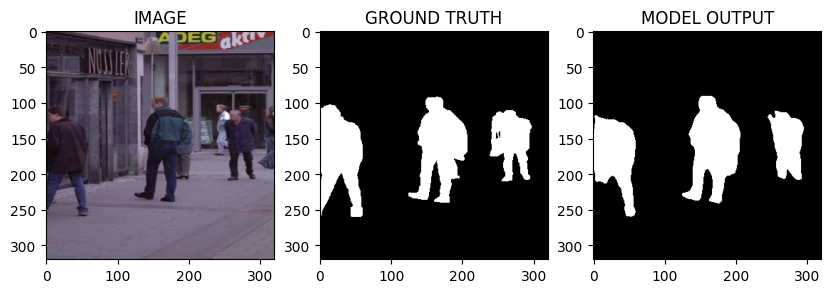

In [98]:
helper.show_image(image, mask, pred_mask.to('cpu').squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya